# Imports

In [1]:
######## Common ########
import pandas as pd
import os
import copy
from collections import Counter
import ast  # To safely evaluate list-like strings
from pathlib import Path
import numpy as np


######## Sound ########
import librosa
import librosa.display
from mutagen.oggvorbis import OggVorbis
# Human Voices Detection
from silero_vad import get_speech_timestamps, save_audio

######## Machine Learning ########
import torch
import torchaudio
from torchaudio.transforms import TimeStretch, FrequencyMasking, TimeMasking, Vol, Spectrogram, MelSpectrogram

######## Data Processing ########
from sklearn.model_selection import train_test_split

######## Visualization ########
# Audio
import IPython.display as ipd
# Ploting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Geographical Maps
import geopandas as gpd
import contextily as ctx

# Read Data

Get inital data info:
* Project directory path
* read csvs into dataframes
* Create taxonomy dictionarts (label->common name)(label->animal class)

In [4]:
# get current directory
project_path = os.getcwd()
train_audio_dir_path = os.path.join(project_path, r"data/train_audio")
soundscapes_audio_dir_path = os.path.join(project_path, r"data/train_soundscapes")

# Read csv files to dfs
taxonomy_df = pd.read_csv(os.path.join(project_path, r"data/taxonomy.csv"))
data_df = pd.read_csv(os.path.join(project_path, r"data/train.csv"))

# Creating dictionaries
label_to_common = taxonomy_df.set_index("primary_label")["common_name"].to_dict()
label_to_class = taxonomy_df.set_index("primary_label")["class_name"].to_dict()

# Data Preprocessing

### Remove Columns
Remove uneccessry columns

In [5]:
data_df.columns

Index(['primary_label', 'secondary_labels', 'type', 'filename', 'collection',
       'rating', 'url', 'latitude', 'longitude', 'scientific_name',
       'common_name', 'author', 'license'],
      dtype='object')

In [6]:
data_df.drop(columns=['author', 'license', 'url', 'latitude', 'longitude', 'type'],inplace=True)

### Drop samples with multiple animal voices
Removing Samples with secondary labels (examples where multiple animals make sound) due insufficiant data for multilabeling

In [7]:
# Remove data with secondary labels
data_df = data_df[data_df['secondary_labels'] == "['']"]

### Add taxonomy columns
Add animal common name and class columns

In [8]:
# Apply dictionaries to create new columns
data_df["common_name"] = data_df["primary_label"].map(label_to_common)
data_df["animal_class"] = data_df["primary_label"].map(label_to_class)

### Add recording length in seconds column
for each audio file, get its length in seconds to save in dataframe

In [9]:
# Function to get the length of the audio file from metadata
def get_audio_length(filename):
    audio_path = os.path.join(train_audio_dir_path, filename)
    audio = OggVorbis(audio_path)
    return audio.info.length  # Returns length in seconds

# Apply the function to the 'filename' column and create a new 'duration' column
data_df['duration_in_seconds'] = data_df['filename'].apply(get_audio_length)

### Save preprocessed data

In [ ]:
# Save the dataframe with the new column to a CSV file
data_df.to_csv('preprocessed data/preprocessed_raw_data.csv', index=False)

# Data Filtering

Read preprocessed data if saved

In [27]:
data_df = pd.read_csv('preprocessed data/preprocessed_raw_data.csv')

Filter dataframe to contain only spicies with an average audio file length larger then 10 seconds and recordings with at least 5 seconds

In [28]:
# Compute average duration per common_name
avg_durations = data_df.groupby("common_name")["duration_in_seconds"].mean()

# Filter common names with average duration > 10
valid_common_names = avg_durations[avg_durations > 10].index

# Filter the original dataframe
filtered_data_df = data_df[data_df["common_name"].isin(valid_common_names)]


# Flter out samples with less then 10 seconds of audio
filtered_data_df = filtered_data_df[filtered_data_df['duration_in_seconds']>=5]

# Flter out samples with less then 10 seconds of audio
# filtered_data_df = filtered_data_df[filtered_data_df['duration_in_seconds']<=60]

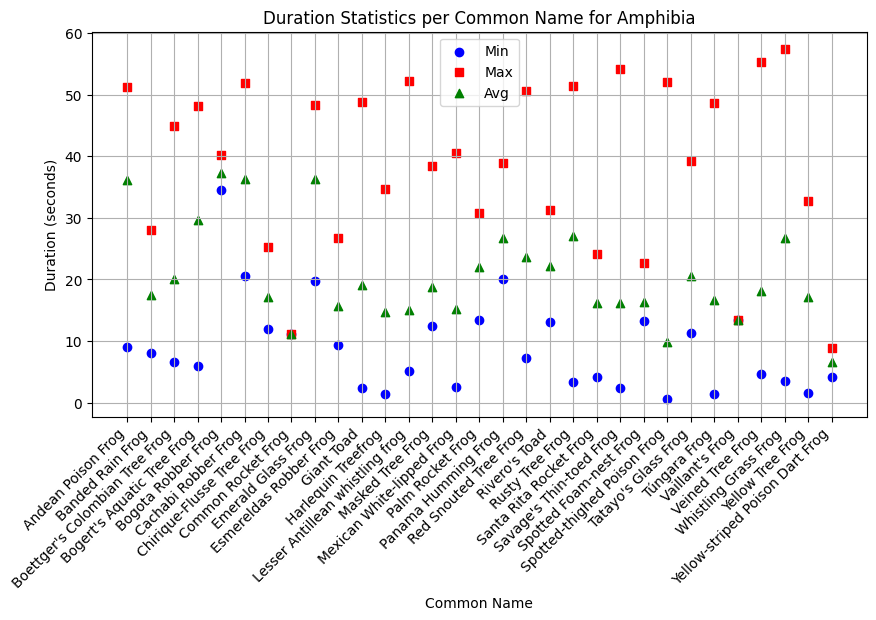

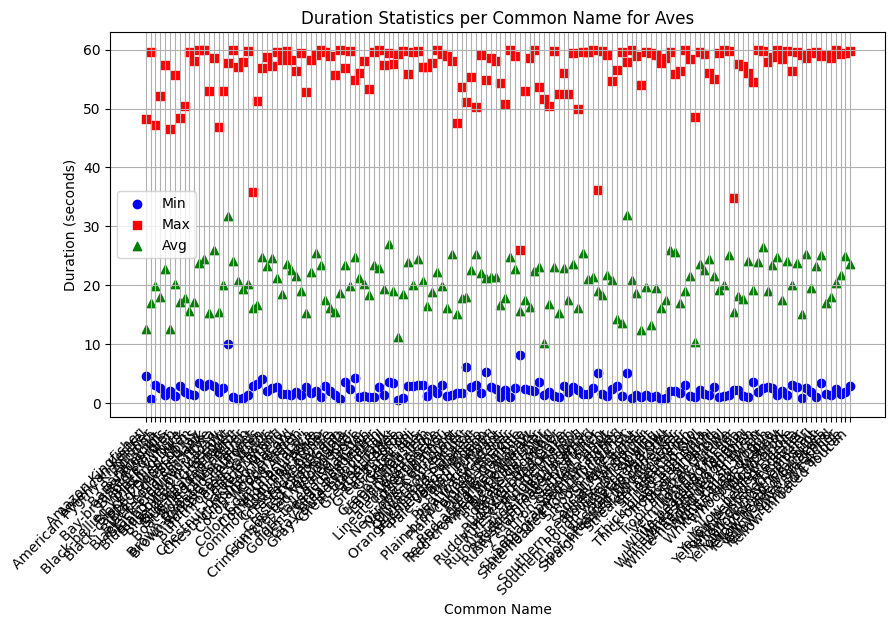

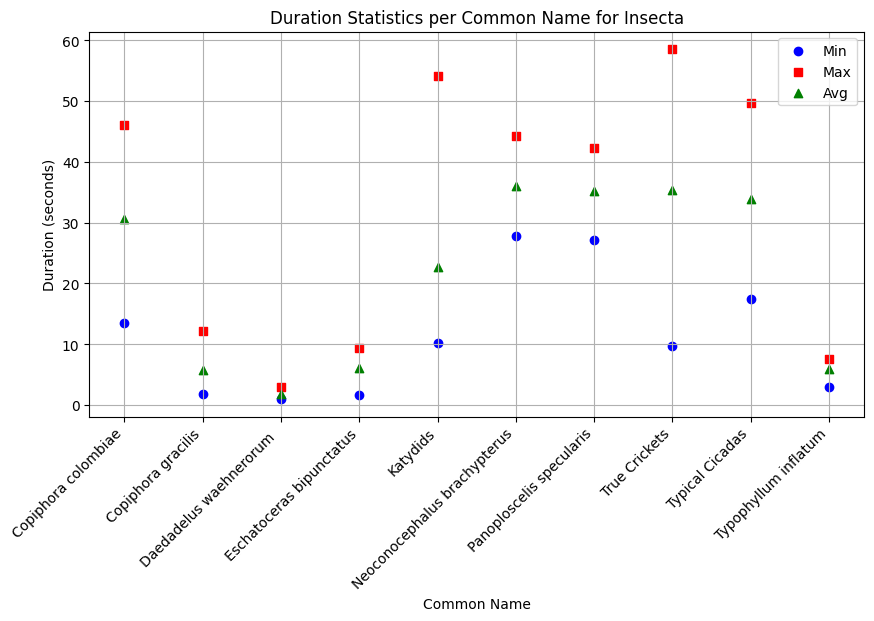

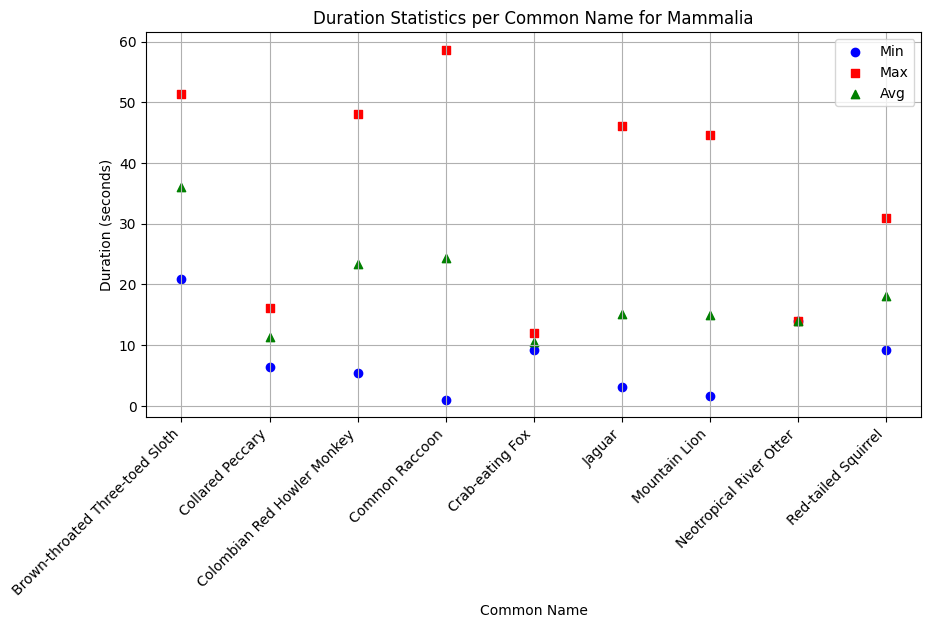

In [29]:
df = data_df[data_df['duration_in_seconds']<=60]

# Group by animal class and common name, then compute min, max, and avg duration
duration_stats = (
    df.groupby(["animal_class", "common_name"])["duration_in_seconds"]
    .agg(["min", "max", "mean"])
    .reset_index()
)

# Plot results for each animal class
for animal_class, group in duration_stats.groupby("animal_class"):
    plt.figure(figsize=(10, 5))
    
    # Plot min, max, and avg as different markers
    plt.scatter(group["common_name"], group["min"], label="Min", color="blue", marker="o")
    plt.scatter(group["common_name"], group["max"], label="Max", color="red", marker="s")
    plt.scatter(group["common_name"], group["mean"], label="Avg", color="green", marker="^")
    
    # Formatting
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Common Name")
    plt.ylabel("Duration (seconds)")
    plt.title(f"Duration Statistics per Common Name for {animal_class}")
    plt.legend()
    plt.grid(True)
    
    # Show plot
    plt.show()

Downsample data to contain no more then 30 recordings for a single animal spicies.

In [35]:
max_samples_per_animal = 30

# Downsample each species to at most 33 samples
downsampled_df = filtered_data_df.groupby("common_name", group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), max_samples_per_animal), random_state=42)
).reset_index(drop=True)

/tmp/ipykernel_1882723/3484384032.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  downsampled_df = filtered_data_df.groupby("common_name", group_keys=False).apply(


Select 4 animals with most recordings from each animal class

In [36]:
num_of_top_most_common = 4
insecta_species = downsampled_df[downsampled_df["animal_class"] == "Insecta"]["common_name"].value_counts().nlargest(num_of_top_most_common).index
mammalia_species = downsampled_df[downsampled_df["animal_class"] == "Mammalia"]["common_name"].value_counts().nlargest(num_of_top_most_common).index
amphibia_species = downsampled_df[downsampled_df["animal_class"] == "Amphibia"]["common_name"].value_counts().nlargest(num_of_top_most_common).index
aves_species = downsampled_df[downsampled_df["animal_class"] == "Aves"]["common_name"].value_counts().nlargest(num_of_top_most_common).index

# Filter data_df to include only the top species from each animal class
downsampled_df = downsampled_df[
    (downsampled_df["common_name"].isin(insecta_species)) |
    (downsampled_df["common_name"].isin(mammalia_species)) |
    (downsampled_df["common_name"].isin(amphibia_species)) |
    (downsampled_df["common_name"].isin(aves_species))
]

Check the balance of classes and animals

/tmp/ipykernel_1882723/1494645154.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="count", ascending=True, inplace=True)


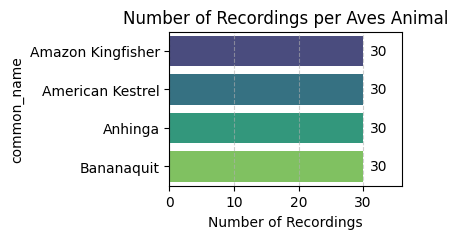

/tmp/ipykernel_1882723/1494645154.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="count", ascending=True, inplace=True)


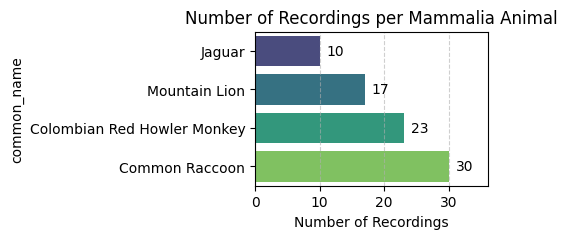

/tmp/ipykernel_1882723/1494645154.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="count", ascending=True, inplace=True)


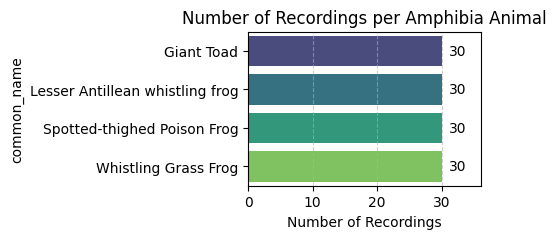

/tmp/ipykernel_1882723/1494645154.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by="count", ascending=True, inplace=True)


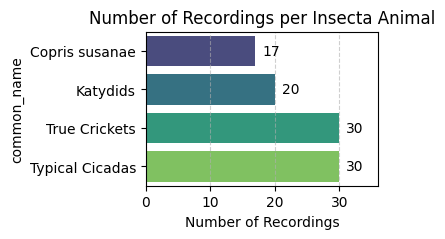

In [37]:
def show_class_and_animal_balance(data_df):
    
    # Create dataframe with animal name, animal class, and count
    animal_counts_df = data_df.groupby(["common_name", "animal_class"]).size().reset_index(name="count")
    
    for c in ["Aves","Mammalia","Amphibia","Insecta"]:
        df = animal_counts_df[animal_counts_df['animal_class']==c]
    
        df.sort_values(by="count", ascending=True, inplace=True)
        
        # Plot horizontal bar chart
        plt.figure(figsize=(3, 2))  # Adjust height for better visualization
        ax = sns.barplot(x="count", y="common_name", data=df, hue="common_name", palette="viridis", legend=False)
        
        
        # Add count numbers to each bar
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', padding=5)
        
        # Adjust x-axis limit for spacing
        max_count = df["count"].max()
        plt.xlim(0, max_count * 1.2)  # Extend the max value by 15%
        
        plt.xlabel("Number of Recordings")
        plt.ylabel("common_name")
        plt.title(f"Number of Recordings per {c} Animal")
        plt.grid(axis="x", linestyle="--", alpha=0.6)
        plt.show()

show_class_and_animal_balance(downsampled_df)

Split data into train, val and test splits while maintaining presence of all animal spricies across the sets

In [38]:
# Stratified train/validation/test split
def stratified_split(df, stratify_col, train_size=0.8, val_size=0.1, test_size=0.1):
    train_df, temp_df = train_test_split(df, train_size=train_size, stratify=df[stratify_col], random_state=42)
    val_df, test_df = train_test_split(temp_df, train_size=val_size / (val_size + test_size), stratify=temp_df[stratify_col], random_state=42)
    return train_df, val_df, test_df

train_df, val_df, test_df = stratified_split(downsampled_df, stratify_col=["animal_class", "primary_label"])

# Data Saving

In [41]:
# Create directory to save preprocessed data
Path("preprocessed data").mkdir(parents=True, exist_ok=True)

# Save dataframes as csvs
train_df.to_csv("preprocessed data/train.csv", index=False)
val_df.to_csv("preprocessed data/validation.csv", index=False)
test_df.to_csv("preprocessed data/test.csv", index=False)